<a href="https://colab.research.google.com/github/adrinafirda/CapstoneProject_Hacktiv8/blob/main/capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.6 MB/s eta 0:00:00


In [5]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
# Set the API token
api_token = userdata.get('REPLICATE_API_TOKEN')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.2-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

In [7]:
import os
import pandas as pd
import replicate

df = pd.read_csv('/content/merged_stock_sentiment_data.csv', na_values=["", " ", "NA", "null", "None", "-"])
df.head()

,Adj Close,Close,High,Low,Open,Volume,Company,Date,Target,Score,Comments,Cleaned_Text,Sentiment,Sentiment_Score
0,8.532785,10.115357,10.135000,9.851786,9.860000,658677600,Apple,2010-09-20,1,0,0,stock market game iphone ipad play,Positive,0.999895
1,8.712500,8.712500,8.897000,8.686500,8.816500,84050000,Amazon,2010-12-13,1,7,5,hussman warning awful time invest,Neutral,0.553402
2,8.778500,8.778500,8.950000,8.679500,8.686000,116210000,Amazon,2010-12-15,1,8,0,awful time invest reflection lost opportunity,Negative,0.982149
3,8.887500,8.887500,8.987500,8.728000,8.843000,93130000,Amazon,2011-02-24,1,5,1,amazon prime streaming disrupt netflix,Negative,0.977377
4,11.446334,13.569286,13.602857,13.282143,13.321429,467832400,Apple,2011-09-12,-1,5,16,personally im fan theyre already beatendown pr...,Negative,0.993987


PREPROCESSING

In [8]:
needed_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment', 'Sentiment_Score']
df = df.dropna(subset=needed_cols).reset_index(drop=True)
df = df.dropna(subset=['Cleaned_Text']).reset_index(drop=True)

In [9]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11915 entries, 0 to 11914
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Adj Close        11915 non-null  float64
 1   Close            11915 non-null  float64
 2   High             11915 non-null  float64
 3   Low              11915 non-null  float64
 4   Open             11915 non-null  float64
 5   Volume           11915 non-null  int64  
 6   Company          11915 non-null  object 
 7   Date             11915 non-null  object 
 8   Target           11915 non-null  int64  
 9   Score            11915 non-null  int64  
 10  Comments         11915 non-null  int64  
 11  Cleaned_Text     11915 non-null  object 
 12  Sentiment        11915 non-null  object 
 13  Sentiment_Score  11915 non-null  float64
dtypes: float64(6), int64(4), object(4)
memory usage: 1.3+ MB


,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0
Company,0
Date,0
Target,0
Score,0


PREPARE

In [ ]:
last_10_days = df.tail(10)

In [ ]:
feature_cols = last_10_days[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment', 'Sentiment_Score']]

In [ ]:
stock_info_text = "\n".join([
    f"{row.Date} | Open: {row.Open} | High: {row.High} | Low: {row.Low} | Close: {row.Close} | Volume: {row.Volume} | Sentiment: {row.Sentiment} ({row.Sentiment_Score})"
    for row in feature_cols.itertuples(index=False)
])

PROMPT

In [ ]:
import json
latest_data = df.tail(10).to_dict(orient='records')

companies = ["Tesla", "Apple", "Amazon"]

for company in companies:
    stock_info_text = df[df["Company"] == company].tail(10).to_dict(orient="records")

    prompt = f"""
    Hi, can you help me? I want to predict the stock prices for {company}.
    Based on the following stock data (Open, High, Low, Close, Volume, and sentiment score),
    create a brief analysis of price trends and predict the closing price for the next three days.

    Stock Data:
    {stock_info_text}

    Please provide:
    1) Predicted next-day Close prices
    2) Key reasons for this prediction
    """

    parameters = {
    "top_k": 10,
    "top_p": 0.9,
    "max_tokens": 256,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.5,
    "stopping_criteria": "length (256 tokens)",
    "stopping_sequence": " "
    }

    response = output.generate([prompt])
    print(f"\n=== Prediction for {company} ===")
    print(response.generations[0][0].text)


=== Prediction for Tesla ===
1) Predicted Next-Day Close Prices:

- Day 1 (Nov 27, 2024): $360.00
- Day 2 (Nov 28, 2024): $362.50
- Day 3 (Nov 29, 2024): $365.00

2) Key Reasons for Prediction:

The provided data shows a generally positive sentiment score for Tesla, which is indicative of bullish market sentiment. The volume of shares traded is also relatively high, suggesting strong investor interest.

- **Nov 22, 2024:** The closing price was $352.55. Despite the high volume, the price didn't show significant movement.

- **Nov 25, 2024:** The closing price remained the same at $338.58. However, the high sentiment score (0.9999144) and the high volume (95890900) suggest underlying strength.

- **Nov 26, 2024:** The closing price slightly increased to $338.23. The sentiment score was still high (0.9999796), and the volume (62295900) was substantial, indicating buying pressure.

Given the consistent high sentiment scores and the substantial trading volumes, it can be inferred that the

EDA

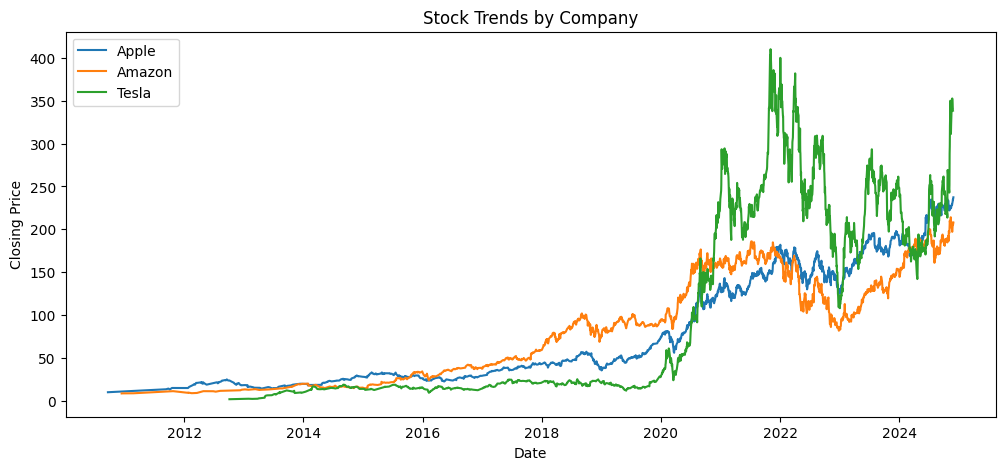

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
for company in df["Company"].unique():
    subset = df[df["Company"] == company]
    plt.plot(pd.to_datetime(subset["Date"]), subset["Close"], label=company)
plt.title("Stock Trends by Company")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()